In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
tf.get_logger().setLevel('ERROR')
from tqdm.keras import TqdmCallback
import multiprocessing as mp
# mp.set_start_method("spawn")

from src.ml.ml_reg import MLP_Model
from src.ml.ml_reg import LSTM_Model
import src

%load_ext autoreload
%autoreload 2

In [2]:
plt.rcParams.update({
    # "text.usetex": True,
    # "font.family": "serif",
    # "font.serif": ["Computer Modern Roman"],
    "font.size": 12,
    "figure.dpi": 100,
})
%matplotlib inline

In [59]:
def pred_plot(y: np.ndarray,
              y_pred: np.ndarray,
              title: str = '',
              ):
    assert y.shape == y_pred.shape, 'y and y_pred must have the same shape'

    if y.ndim == 1:
        y = y.reshape(-1, 1)
    if y_pred.ndim == 1:
        y_pred = y_pred.reshape(-1, 1)

    n_outputs = y.shape[1]

    fig, ax = plt.subplots(n_outputs, 2, figsize=(12, 6 * n_outputs))
    ax = ax.reshape(n_outputs, 2)

    for i in range(n_outputs):
        ax[i, 0].scatter(y[:, i], y_pred[:, i])
        lims = [
            np.min([ax[i, 0].get_xlim(), ax[i, 0].get_ylim()]),
            np.max([ax[i, 0].get_xlim(), ax[i, 0].get_ylim()]),
        ]
        ax[i, 0].plot(lims, lims, 'k-', alpha=0.75, zorder=0)
        ax[i, 0].grid()
        ax[i, 0].set_aspect('equal')
        ax[i, 0].set_xlim(lims)
        ax[i, 0].set_ylim(lims)
        ax[i, 0].set_xlabel('Actual Y')
        ax[i, 0].set_ylabel('Predicted Y')
        ax[i, 0].set_title(f'{title} - Output {i} Preds')

        diff = (y_pred[:, i] - y[:, i]) * 1000

        ax[i, 1].hist(diff, bins=30)
        ax[i, 1].set_xlabel('Prediction Error / um')
        ax[i, 1].set_ylabel('No Occurances')
        ax[i, 1].set_title(f'{title} - Output {i} Hist')
   
    fig.tight_layout()
    return fig, ax

In [88]:
exps = ['Test 11',
        'Test 14',
        'Test 15',
        'Test 16',
        'Test 17',
        'Test 18',
        'Test 19',
        'Test 21',
        ]
exps = [src.load(exp) for exp in exps]
dfs = [exp.features.iloc[1:] for exp in exps]

In [89]:
main_df = pd.concat(dfs)
main_df = main_df.drop(columns=['Runout',
                                'Form error',
                                'Peak radius',
                                'Radius diff',
                                # 'Mean radius',
                                'Avg probe',
                                'Probe diff',
                                ])#.drop([0, 1, 2, 3])
main_df.reset_index(drop=True, inplace=True)
print(f'Main df : {main_df.shape[0]} rows x {main_df.shape[1]} cols')
main_df.head()

Main df : 1067 rows x 8 cols


,RMS,Kurtosis,Amplitude,Skewness,Freq 10 kHz,Freq 35 kHz,Freq 134 kHz,Mean radius
0,0.039208,15.358375,1.581795,0.019882,29.507773,36.712393,16.873432,0.672499
1,0.289873,11.720536,8.527955,0.061386,31.941039,52.078281,39.609882,0.671830
2,0.720448,6.666400,7.369736,-0.095615,36.136609,61.848164,47.254065,0.669854
3,0.949587,5.552429,9.247926,-0.085875,35.081427,66.172557,48.616375,0.668865
4,0.974782,5.480675,8.517215,-0.073499,34.281257,66.067365,48.321941,0.668145


In [90]:
input_df = main_df.iloc[:, :-1]
print(f'Input df : {input_df.shape[0]} rows x {input_df.shape[1]} cols')
input_df.head()

Input df : 1067 rows x 7 cols


,RMS,Kurtosis,Amplitude,Skewness,Freq 10 kHz,Freq 35 kHz,Freq 134 kHz
0,0.039208,15.358375,1.581795,0.019882,29.507773,36.712393,16.873432
1,0.289873,11.720536,8.527955,0.061386,31.941039,52.078281,39.609882
2,0.720448,6.666400,7.369736,-0.095615,36.136609,61.848164,47.254065
3,0.949587,5.552429,9.247926,-0.085875,35.081427,66.172557,48.616375
4,0.974782,5.480675,8.517215,-0.073499,34.281257,66.067365,48.321941


In [91]:
target_df = main_df.iloc[:, -1:]
print(f'Target df : {target_df.shape[0]} rows x {target_df.shape[1]} cols')
target_df.head()

Target df : 1067 rows x 1 cols


,Mean radius
0,0.672499
1,0.671830
2,0.669854
3,0.668865
4,0.668145


### MLP

In [39]:
mlp = MLP_Model(modelParams={'nLayers': 3,
                             'nUnits': [64, 64, 64],
                             'activation': 'relu',
                             'dropout': 0.01,
                             },
                compileParams={'optimizer': 'adam',
                               'loss': 'mse',
                               'metrics': ['root_mean_squared_error',
                                           'mean_absolute_error',
                                           'r2_score'
                                           ],
                               },
                fitParams={'epochs': 1000,
                            'batch_size': 32,
                            },
                inputData=input_df.values,
                targetData=target_df.values,
                testFrac=0.2,
                shuffle=True,
                randomState=42,
                tb=False,
                tbLogDir='MultiOutput',
                )

In [12]:
mlp.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 7)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,177 (133.50 KB)

 Trainable params: 34,177 (133.50 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
cvScores = mlp.cv(nSplits=5, nRepeats=5)

CV:   4%|▍         | 1/25 [02:27<59:09, 147.88s/it]


KeyboardInterrupt: 

In [40]:
mlp.fit()

100%|██████████| 1000/1000 [01:29<00:00, 11.14epoch/s, loss=5.15e-6, mean_absolute_error=0.00169, r2_score=0.943, root_mean_squared_error=0.00227, val_loss=2.25e-5, val_mean_absolute_error=0.00295, val_r2_score=0.705, val_root_mean_squared_error=0.00475] 


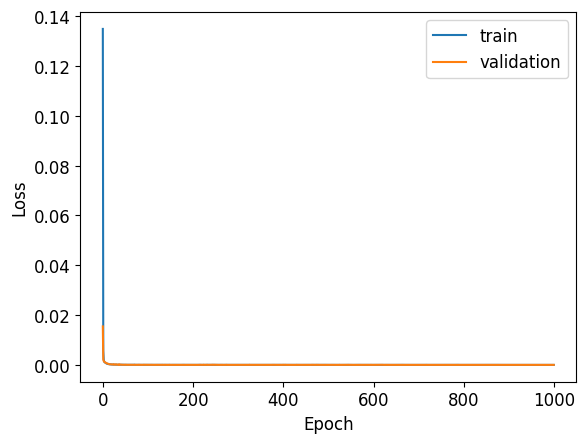

In [41]:
fig, ax = mlp.plot_loss()

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step


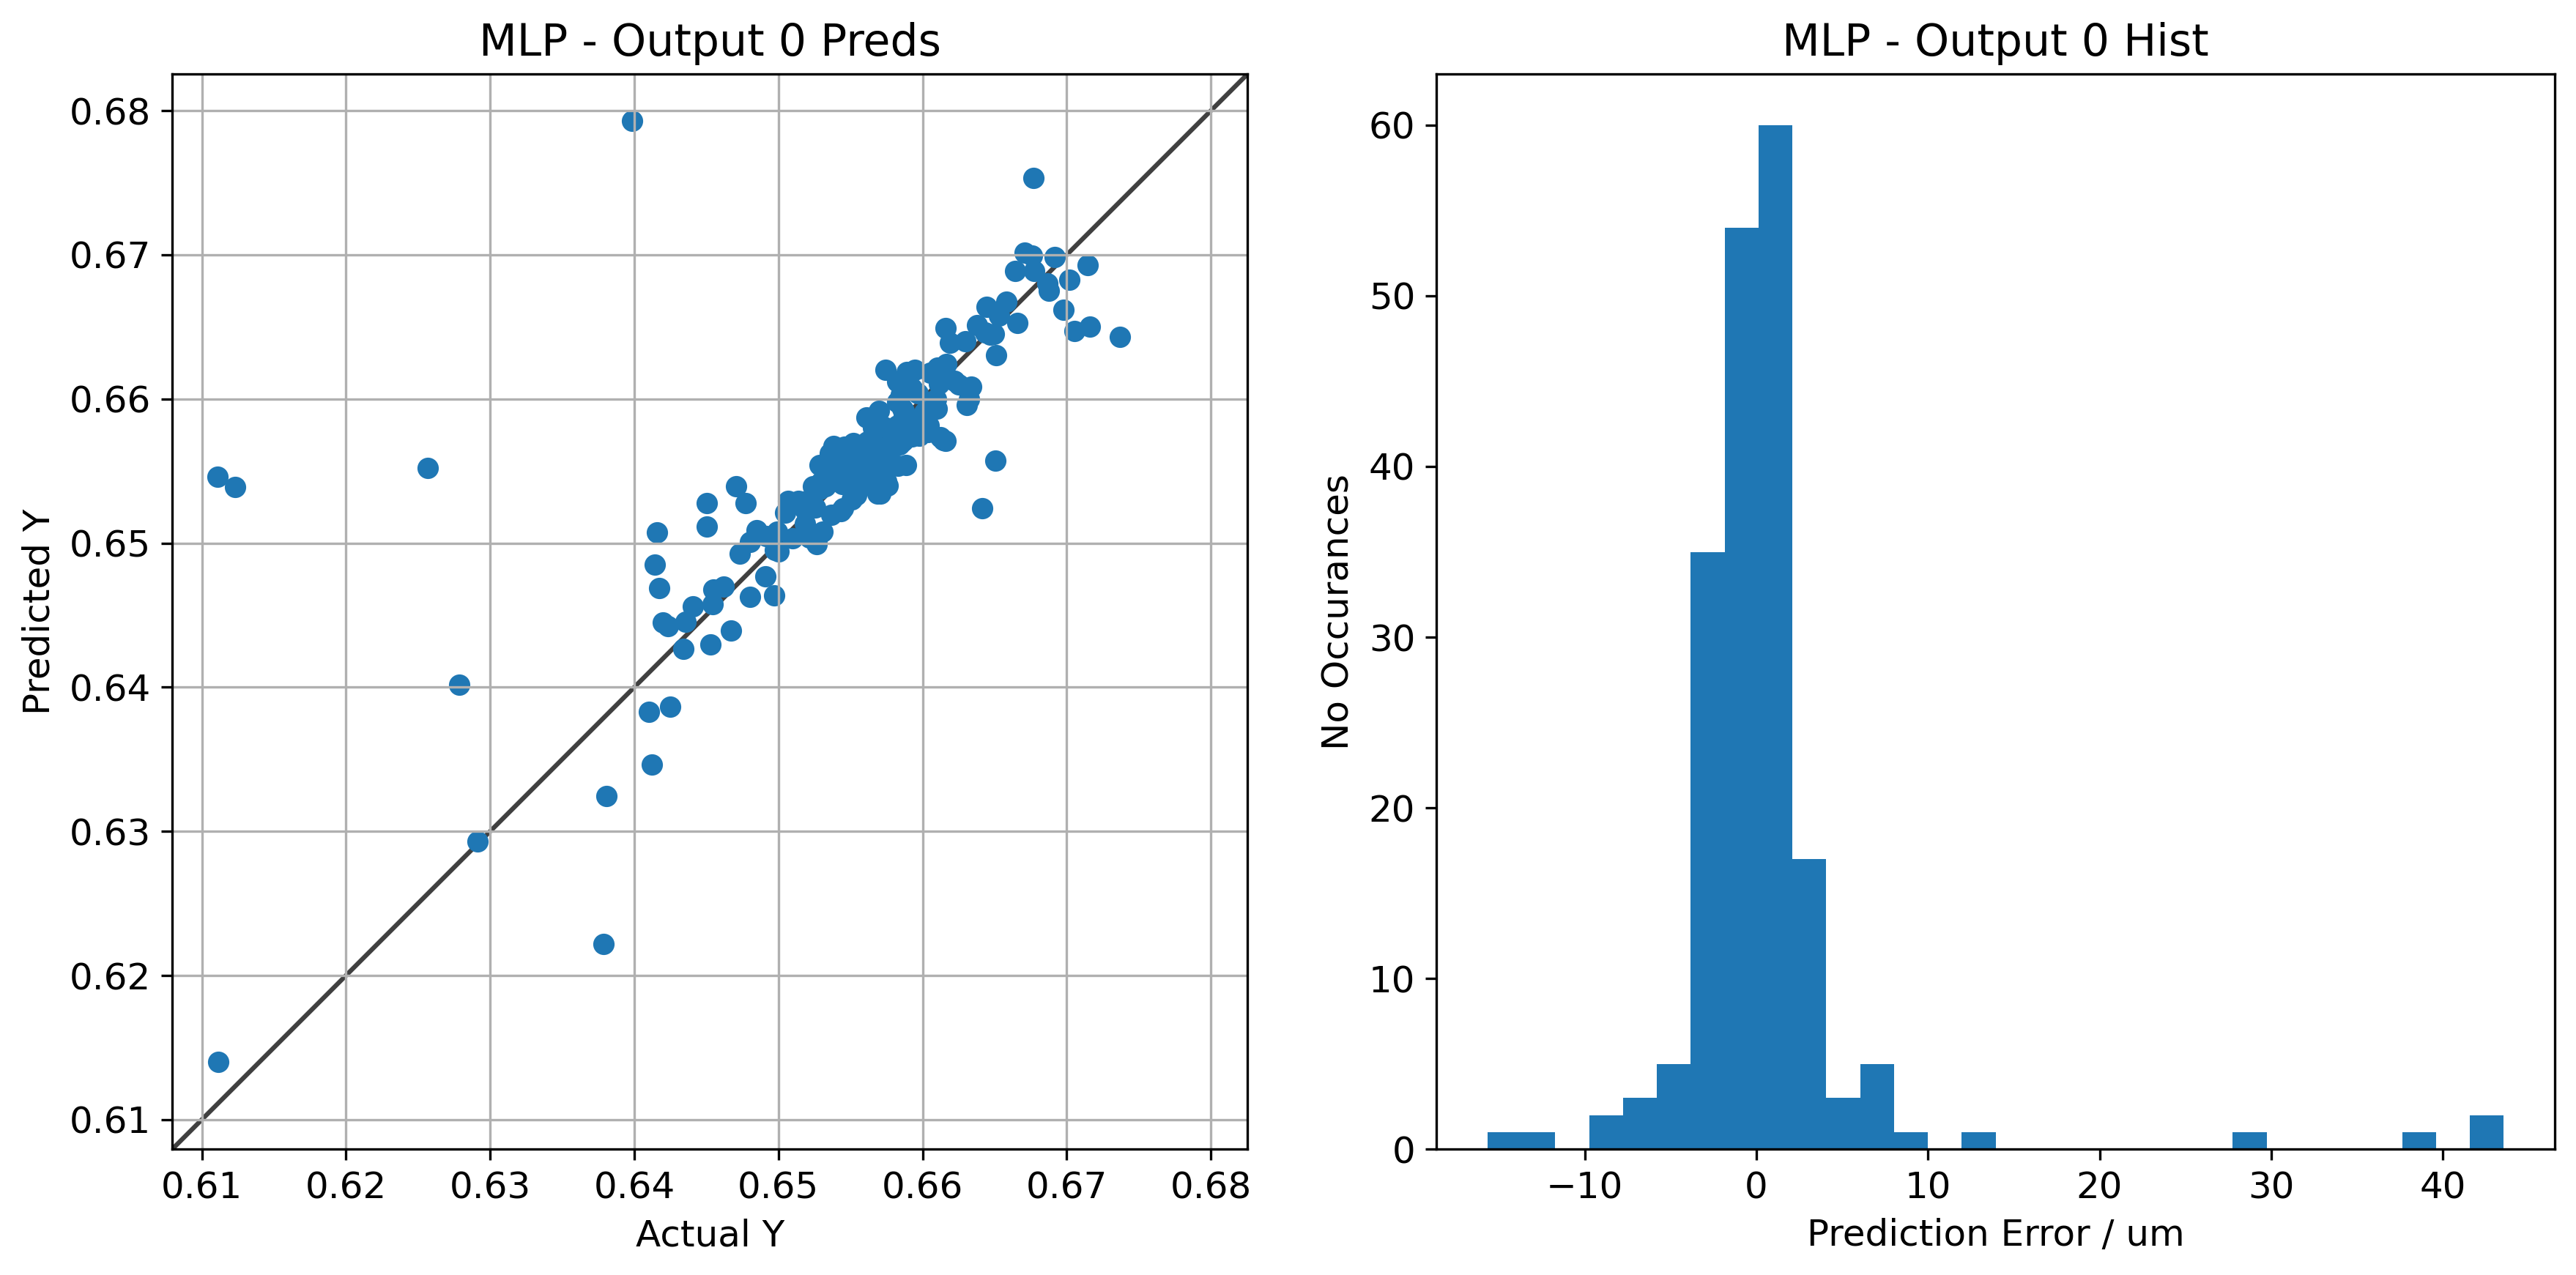

In [62]:
y_pred = mlp.predict(x=mlp.testData[0])
fig, ax = pred_plot(mlp.testData[1], y_pred, 'MLP')
fig.set_dpi(300)

In [43]:
sc = mlp.score(printout=True)

Test Data:
	mean_squared_error: 0.0000
	root_mean_squared_error: 0.0064
	mean_absolute_error: 0.0030
	r2_score: 0.5437


### LSTM

In [138]:
lstm = LSTM_Model(modelParams={'seqLen': 15,
                               'nLSTMLayers': 2,
                               'nLSTMUnits':[64, 64],
                               'nDenseLayers': 1,
                               'nDenseUnits': [16],
                               'activation': 'relu',
                               'dropout': 0.01,
                               },
                  compileParams={'optimizer': 'adam',
                                 'loss': 'mse',
                                 'metrics': ['root_mean_squared_error',
                                             'mean_absolute_error',
                                             'r2_score'
                                             ],
                                 },
                  fitParams={'epochs': 2000,
                              'batch_size': 32,
                              'validation_split': 0.1,
                              },
                  inputData=input_df.values,
                  targetData=target_df.values,
                  endPointsData=[len(df) for df in dfs],
                  testFrac=0.2,
                  shuffle=True,
                #   randomState=42,
                  tb=True,
                  tbLogDir='MultiOutput',
                  )

In [93]:
lstm.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 15, 7)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 15, 64)         │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ (None, 15, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 52,513 (205.13 KB)

 Trainable params: 52,513 (205.13 KB)

 Non-trainable params: 0 (0.00 B)

In [94]:
cvScores = lstm.cv(nSplits=5, nRepeats=5)

CV:   0%|          | 0/25 [00:01<?, ?it/s]


KeyboardInterrupt: 

In [139]:
lstm.fit()

100%|██████████| 2000/2000 [12:11<00:00,  2.73epoch/s, loss=7.81e-7, mean_absolute_error=0.000705, r2_score=0.992, root_mean_squared_error=0.000883, val_loss=8.55e-7, val_mean_absolute_error=0.000681, val_r2_score=0.989, val_root_mean_squared_error=0.000924]


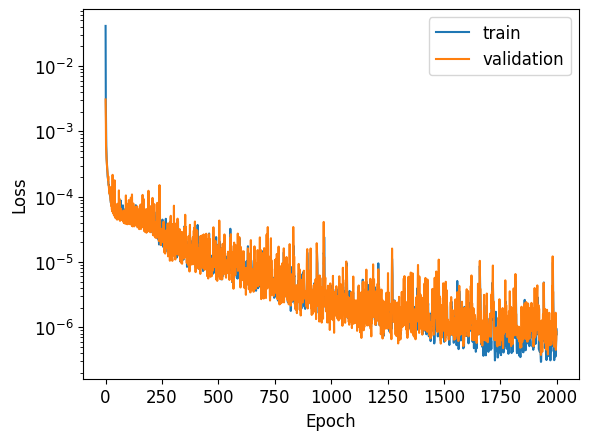

In [140]:
fig, ax = lstm.plot_loss()
ax.set_yscale('log')

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step


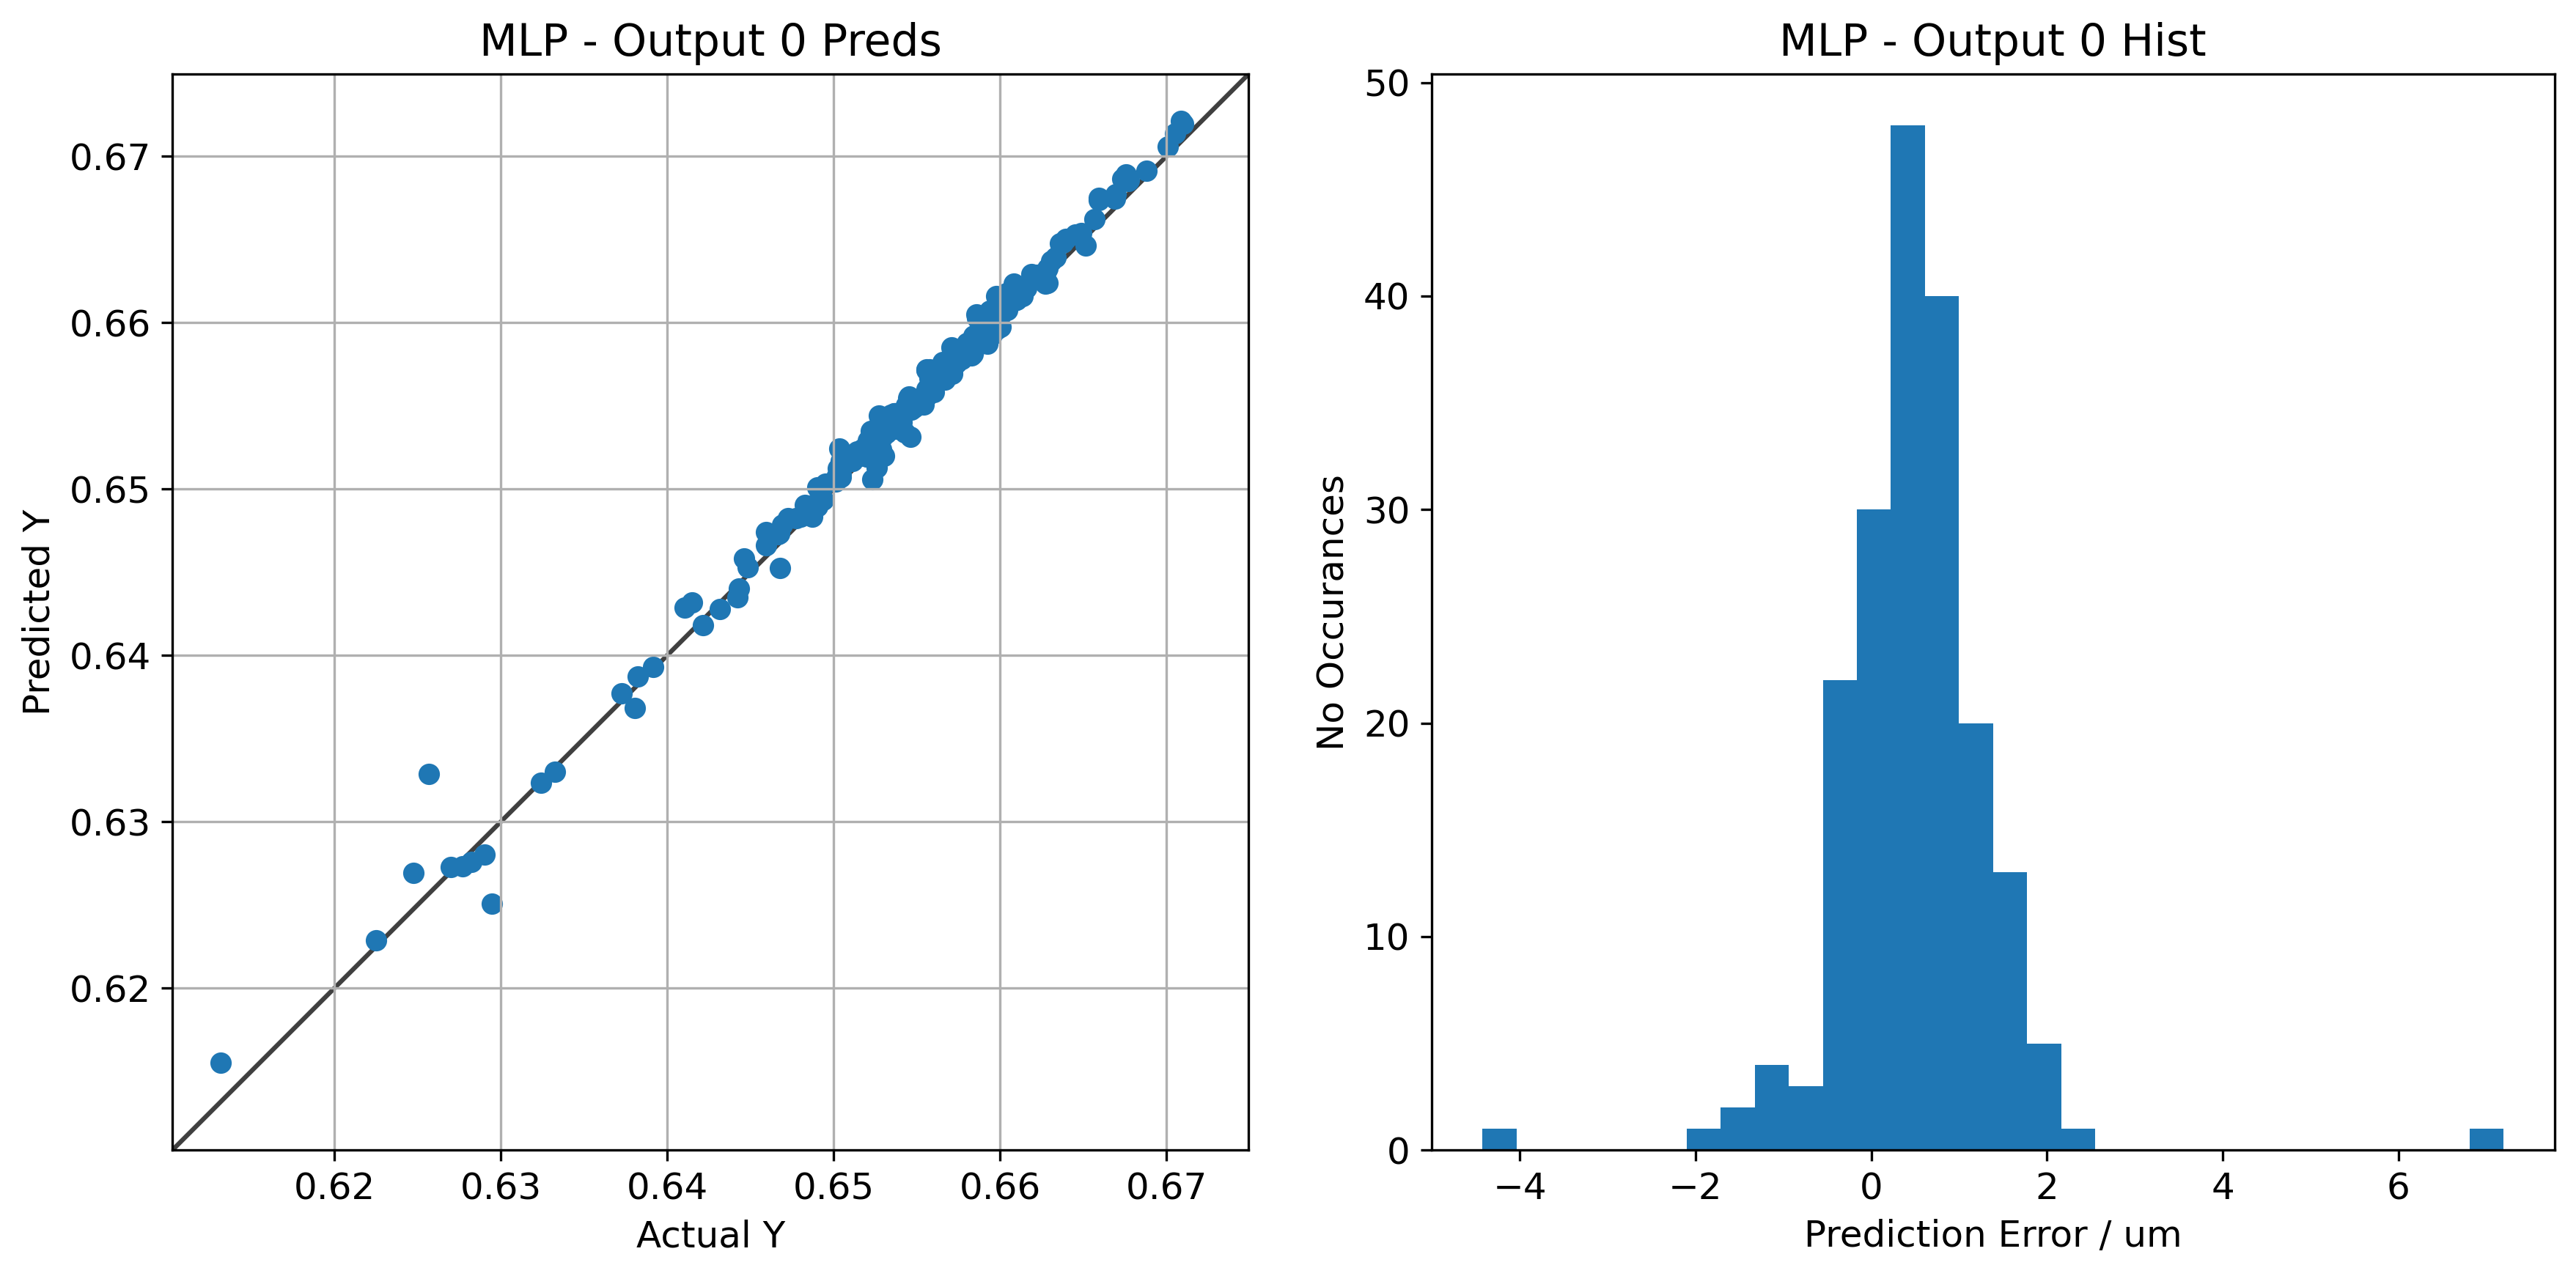

In [141]:
y_pred = lstm.predict(x=lstm.testData[0])
fig, ax = pred_plot(lstm.testData[1], y_pred, 'MLP')
fig.set_dpi(300)

Text(0, 0.5, 'Predicted Mean Radius (mm)')

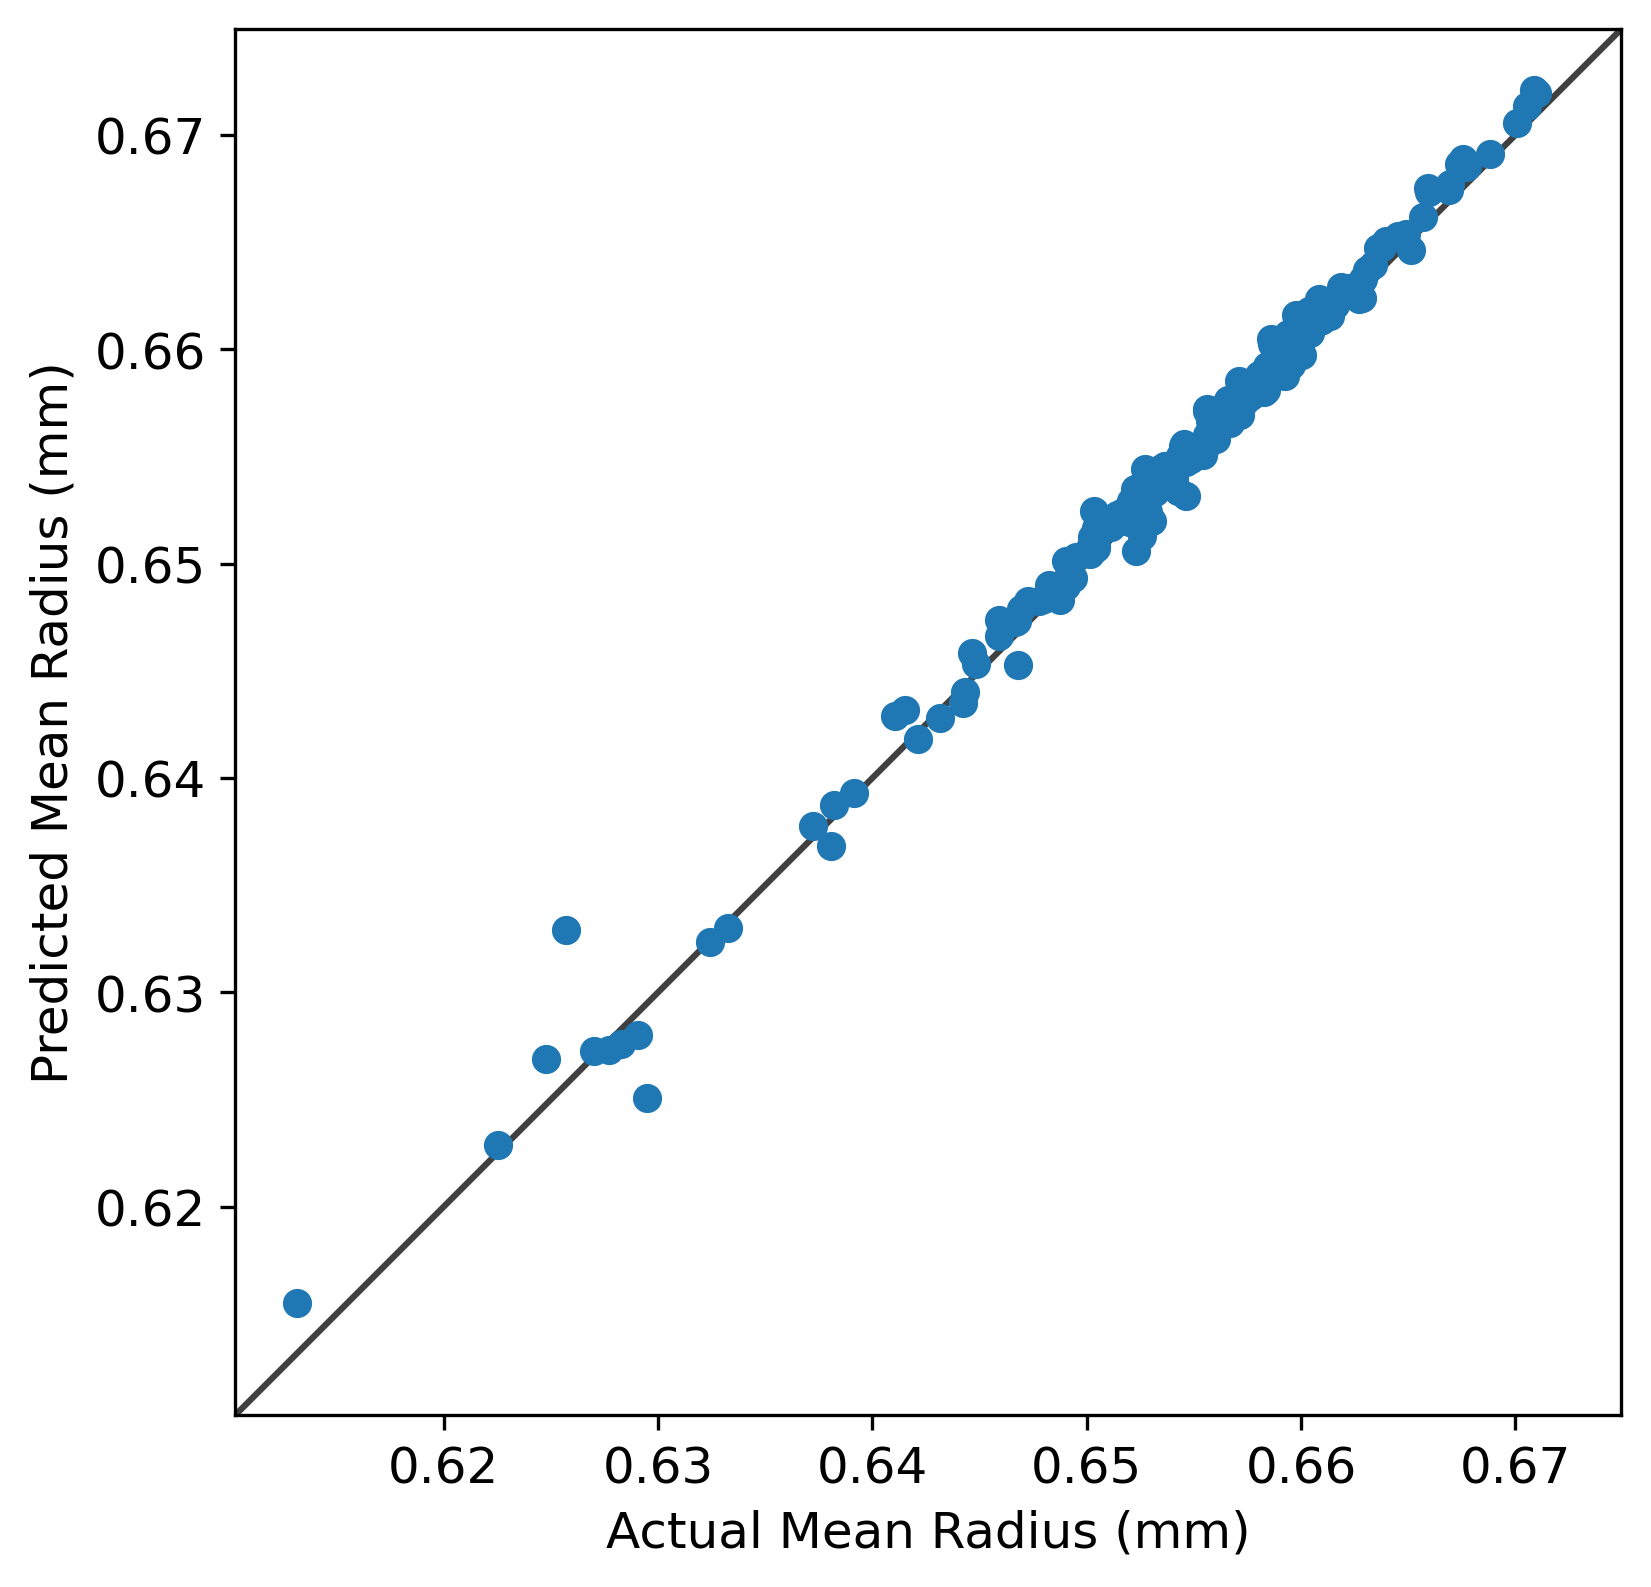

In [142]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6), dpi=300)

ax.scatter(lstm.testData[1], y_pred)
lims = [
    np.min(ax.get_xlim() + ax.get_ylim()),
    np.max(ax.get_xlim() + ax.get_ylim()),
]
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
# ax.grid()
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.set_xlabel('Actual Mean Radius (mm)', fontsize=12)
ax.set_ylabel('Predicted Mean Radius (mm)', fontsize=12)

In [143]:
sc = lstm.score(printout=True)

Test Data:
	mean_squared_error: 0.0000
	root_mean_squared_error: 0.0010
	mean_absolute_error: 0.0007
	r2_score: 0.9879


In [144]:
sc

({'mean_squared_error': 1.0757833e-06,
  'root_mean_squared_error': 0.0010371997,
  'mean_absolute_error': 0.0007350623,
  'r2_score': 0.987863},
 [{'mean_squared_error': 1.0757833e-06,
   'root_mean_squared_error': 0.0010371997,
   'mean_absolute_error': 0.0007350623,
   'r2_score': 0.987863}])

In [145]:
endpoints = [len(df) for df in dfs]
endpoints = np.subtract(endpoints, 14)
endpoints = [0] + np.cumsum(endpoints).tolist()
print(endpoints)

[0, 125, 236, 363, 490, 615, 736, 862, 955]


In [146]:
from matplotlib.ticker import MultipleLocator

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


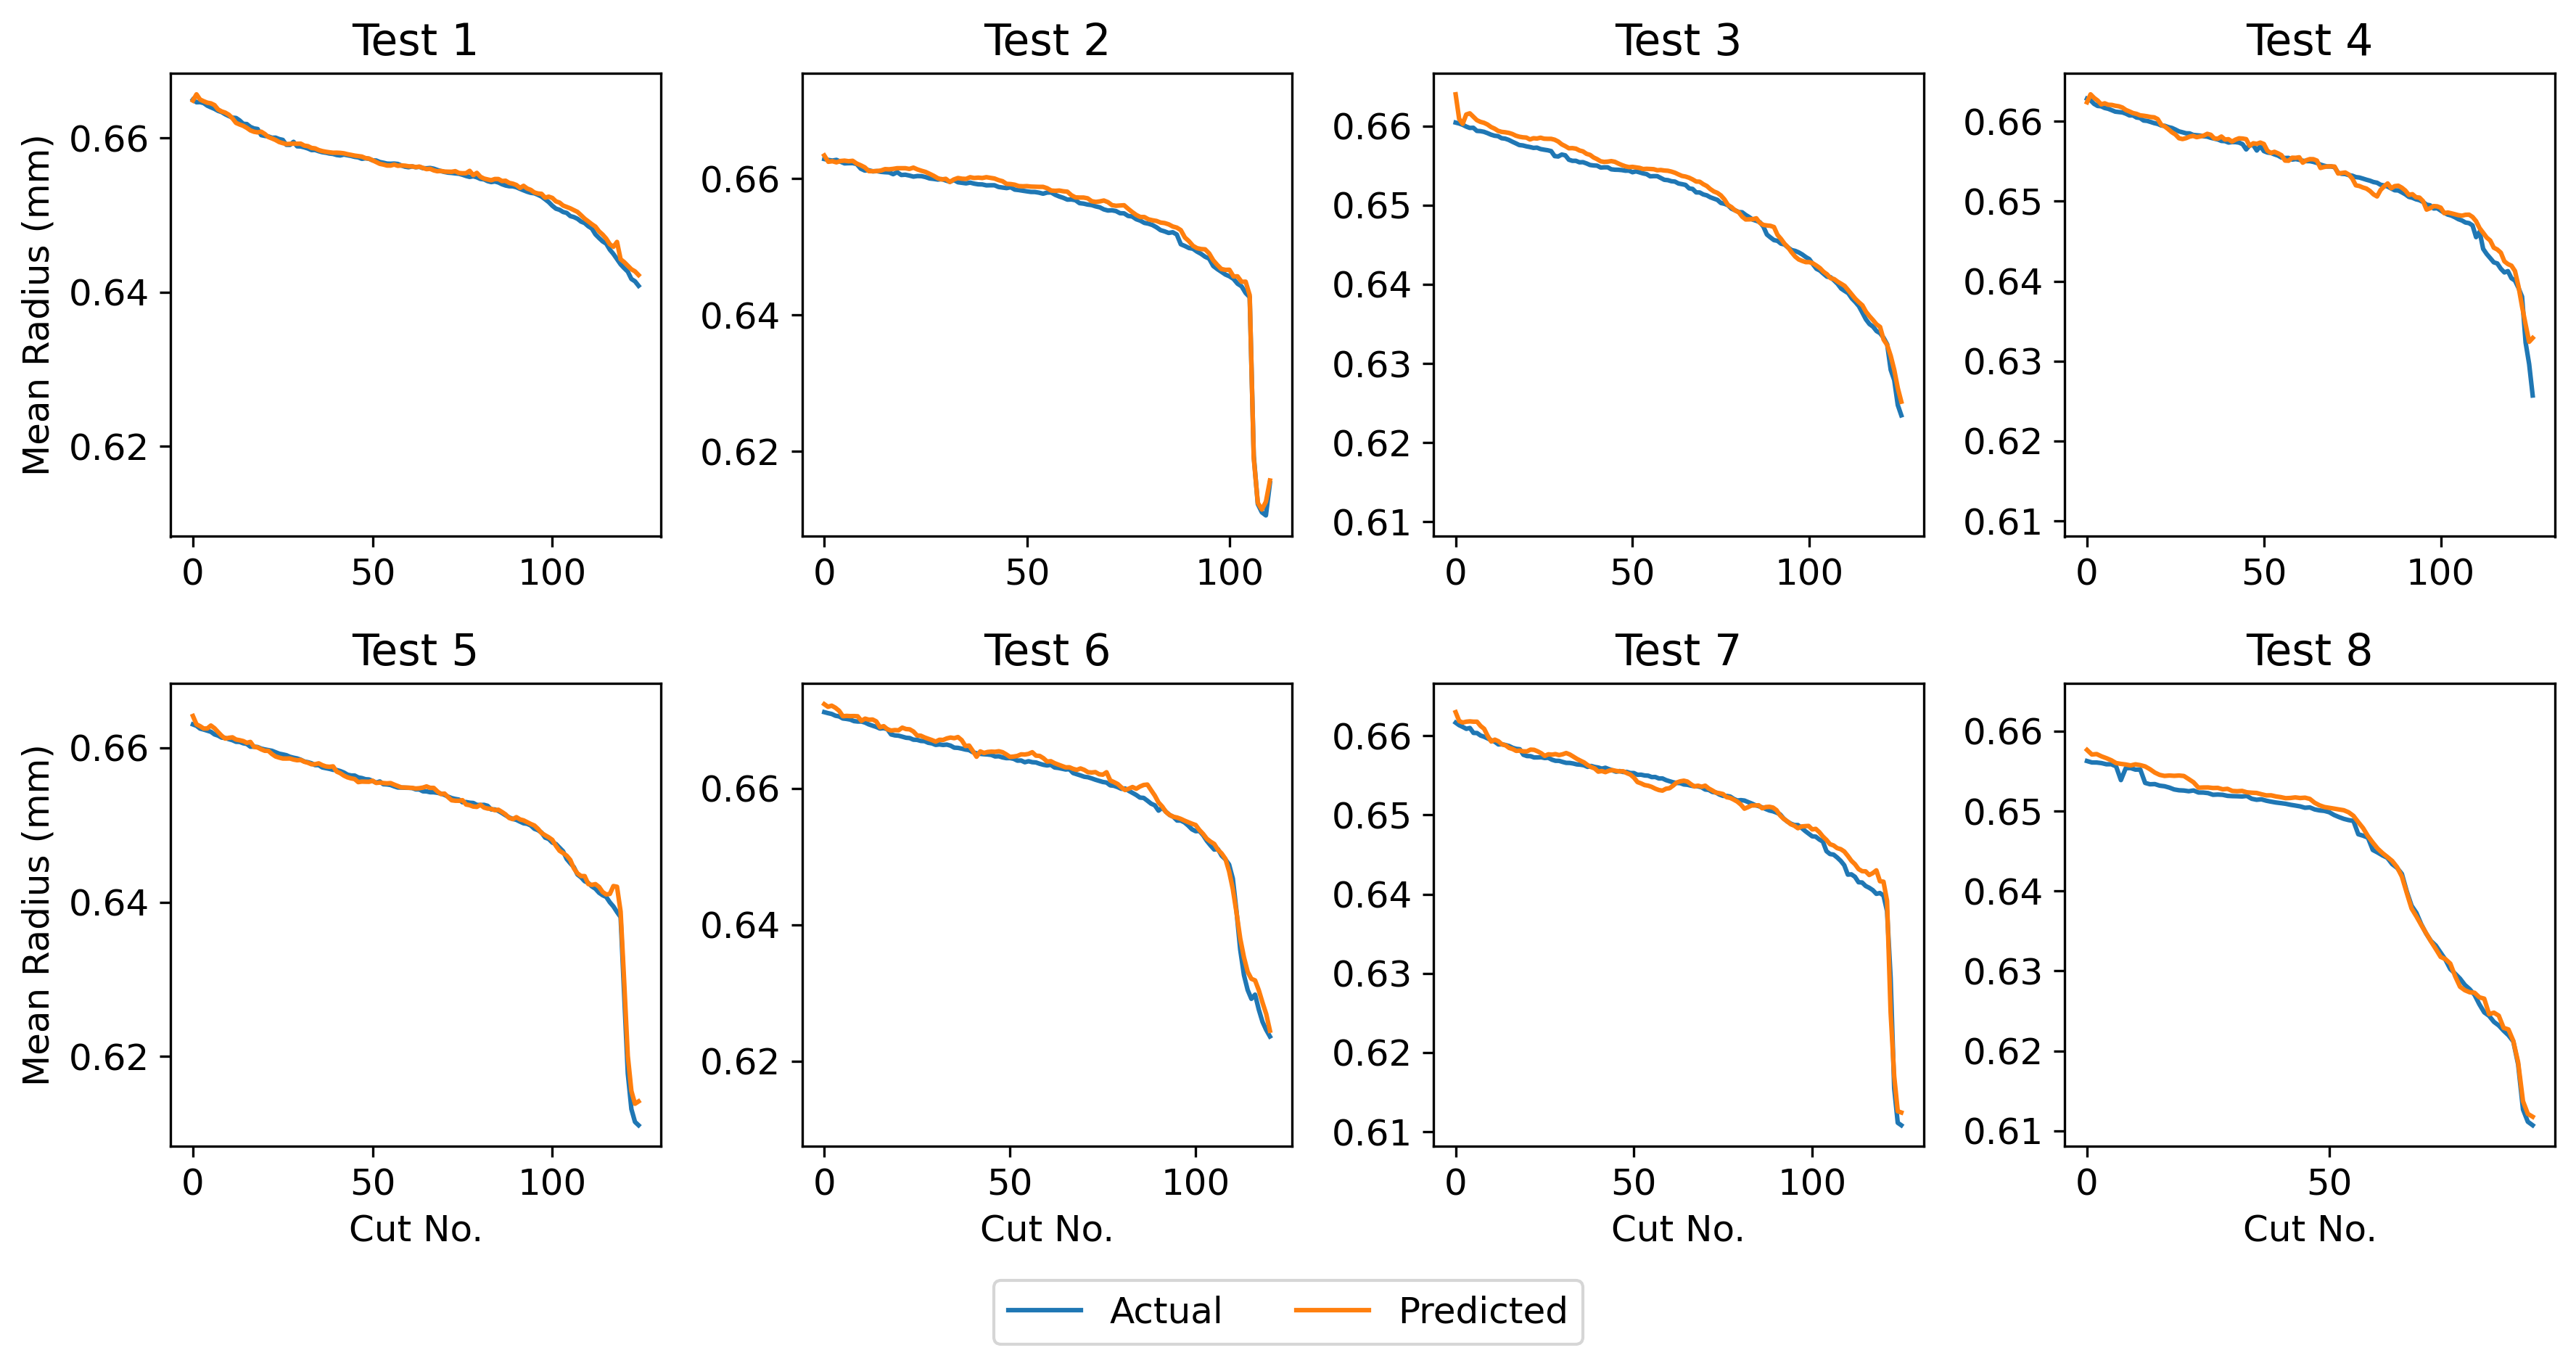

In [150]:
pred_seq = lstm.predict(lstm.seqData[0])
fig, ax = plt.subplots(2, 4, figsize=(12, 6), dpi=300, sharey='col')
ax = ax.ravel()

for i, df in enumerate(dfs):
    ax[i].plot(lstm.seqData[1][endpoints[i]:endpoints[i+1], 0], label='Actual', color='C0')
    ax[i].plot(pred_seq[endpoints[i]:endpoints[i+1], 0], label='Predicted', color='C1')
    ax[i].set_title(f'Test {i+1}')
    if i > 3:
        ax[i].set_xlabel('Cut No.')
    if i % 4 == 0:
        ax[i].set_ylabel('Mean Radius (mm)')
    ax[i].xaxis.set_major_locator(MultipleLocator(50))
fig.legend(['Actual', 'Predicted'], loc='upper center', ncol=2, bbox_to_anchor=(0.5, 0.02))

fig.tight_layout()
